In [1]:
from jupyterthemes import jtplot
from tensorflow import set_random_seed
set_random_seed(42)
jtplot.style()
# Constantes
SEED = 42
PNLN = 0.0097
m = 64
tau = 1
delta = 1

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from keras import regularizers
from tensorflow import keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [3]:
from Funciones import GenersConjuntos
from Funciones import plot_history

In [4]:
# La principal diferencia radica en el uso de la regularizacion L2
def ModMLPReg(show=True):
    inputs = keras.Input(shape=(m))
    x = layers.Dense(64, activation='sigmoid',activity_regularizer=regularizers.l2(PNLN))(inputs)
    x = layers.Dense(128, activation='relu',activity_regularizer=regularizers.l2(PNLN))(x)
    x = layers.Dense(256, activation='relu',activity_regularizer=regularizers.l2(PNLN))(x)
    outputs = layers.Dense(delta, activation='linear',activity_regularizer=regularizers.l2(PNLN))(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')
    
    if(show):
        model.summary()
    
    return model

<h3> Lectura y analisis de la serie de tiempo </h3>

Para comenzar se lee la serie de tiempo desde el archivo csv

In [5]:
TS = pd.read_csv('TimesSeries\Electric_Production.csv')

In [6]:
TS.info() # Se reviza que la serie de tiempo no tenga nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
DATE     397 non-null object
Value    397 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


La serie de tiempo es tomada desde la columna value

In [7]:
serie = TS.Value
mean = serie.mean()
std = serie.std()

Se pueden revizar su media, su maximo, su minimo, y su promedio

In [8]:
print('Media:', serie.mean())
print('Maximo:', serie.max())
print('Minimo:', serie.min())
print('STD:', serie.std())

Media: 88.84721763224182
Maximo: 129.4048
Minimo: 55.3151
STD: 15.387833664730902


La serie es convertiza a numpy array para un mejor manejo, a su vez es ploteada para observar su forma

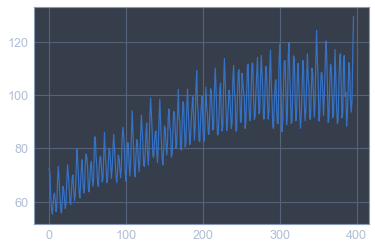

In [9]:
serie = np.array(serie)
plt.plot(serie)
plt.show()

Posteriormente se estandariza la serie y se obtienen los conjuntos de datos con los cuales se ha de entrenar la red

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test=  GenersConjuntos(serie, 0.3, 0.2)

In [11]:
X_val.shape

(47, 64)

<h3> Diseño y entrenamiento de la red neuronal </h3>

In [12]:
model = ModMLPReg()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "forecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 45,761
Trainable params: 45,761
Non-trainable params: 0
_________________________________________________________________


Una vez que el modelo esta creado se compila y se entrena.

En la compilación se utiliza como funcion de perdida el Error cuadratico medio en convinacion con el gradiente estocastico, el tercer parametro son las metricas en este caso se utilizan el error absoluto medio, el error cuadratico medio y accuracy, aunque la ultima no es una buena referencia cuando se realiza prediccion de series de tiempo (forcasting) es más comun su utilización en clasificación.

In [13]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae', 'mse','accuracy'])

In [14]:
#callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    batch_size=64,
                    #callbacks=[callback],
                    epochs=1000,
                    validation_data=(X_val, y_val))

test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])
print('Test mse:', test_scores[2])
print('Test acc:', test_scores[3])

Train on 186 samples, validate on 47 samples
Epoch 1/2000
186/186 [==============================] - 1s 6ms/sample - loss: 1.1338 - mean_absolute_error: 0.6987 - mean_squared_error: 0.7629 - acc: 0.0000e+00 - val_loss: 0.7719 - val_mean_absolute_error: 0.5300 - val_mean_squared_error: 0.4055 - val_acc: 0.0000e+00
Epoch 2/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.8791 - mean_absolute_error: 0.5746 - mean_squared_error: 0.5115 - acc: 0.0000e+00 - val_loss: 0.6670 - val_mean_absolute_error: 0.4700 - val_mean_squared_error: 0.3028 - val_acc: 0.0000e+00
Epoch 3/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.7673 - mean_absolute_error: 0.5207 - mean_squared_error: 0.4018 - acc: 0.0000e+00 - val_loss: 0.6016 - val_mean_absolute_error: 0.4207 - val_mean_squared_error: 0.2396 - val_acc: 0.0000e+00
Epoch 4/2000
186/186 [==============================] - 0s 247us/sample - loss: 0.6964 - mean_absolute_error: 0.4767 - mean_squared_error: 0.

Epoch 31/2000
186/186 [==============================] - 0s 190us/sample - loss: 0.3672 - mean_absolute_error: 0.2142 - mean_squared_error: 0.0722 - acc: 0.0000e+00 - val_loss: 0.3293 - val_mean_absolute_error: 0.1521 - val_mean_squared_error: 0.0382 - val_acc: 0.0000e+00
Epoch 32/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.3639 - mean_absolute_error: 0.2130 - mean_squared_error: 0.0703 - acc: 0.0000e+00 - val_loss: 0.3238 - val_mean_absolute_error: 0.1372 - val_mean_squared_error: 0.0351 - val_acc: 0.0000e+00
Epoch 33/2000
186/186 [==============================] - 0s 196us/sample - loss: 0.3598 - mean_absolute_error: 0.2079 - mean_squared_error: 0.0687 - acc: 0.0000e+00 - val_loss: 0.3225 - val_mean_absolute_error: 0.1410 - val_mean_squared_error: 0.0353 - val_acc: 0.0000e+00
Epoch 34/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.3565 - mean_absolute_error: 0.2051 - mean_squared_error: 0.0671 - acc: 0.0000e+00 - val_loss: 0.32

186/186 [==============================] - 0s 166us/sample - loss: 0.3043 - mean_absolute_error: 0.1730 - mean_squared_error: 0.0508 - acc: 0.0000e+00 - val_loss: 0.2820 - val_mean_absolute_error: 0.1393 - val_mean_squared_error: 0.0322 - val_acc: 0.0000e+00
Epoch 62/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.3032 - mean_absolute_error: 0.1728 - mean_squared_error: 0.0510 - acc: 0.0000e+00 - val_loss: 0.2822 - val_mean_absolute_error: 0.1423 - val_mean_squared_error: 0.0331 - val_acc: 0.0000e+00
Epoch 63/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.3025 - mean_absolute_error: 0.1728 - mean_squared_error: 0.0511 - acc: 0.0000e+00 - val_loss: 0.2820 - val_mean_absolute_error: 0.1439 - val_mean_squared_error: 0.0337 - val_acc: 0.0000e+00
Epoch 64/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.3010 - mean_absolute_error: 0.1727 - mean_squared_error: 0.0503 - acc: 0.0000e+00 - val_loss: 0.2804 - val_mean_

186/186 [==============================] - 0s 145us/sample - loss: 0.2788 - mean_absolute_error: 0.1638 - mean_squared_error: 0.0467 - acc: 0.0000e+00 - val_loss: 0.2614 - val_mean_absolute_error: 0.1404 - val_mean_squared_error: 0.0322 - val_acc: 0.0000e+00
Epoch 92/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2783 - mean_absolute_error: 0.1634 - mean_squared_error: 0.0464 - acc: 0.0000e+00 - val_loss: 0.2610 - val_mean_absolute_error: 0.1408 - val_mean_squared_error: 0.0323 - val_acc: 0.0000e+00
Epoch 93/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.2776 - mean_absolute_error: 0.1637 - mean_squared_error: 0.0463 - acc: 0.0000e+00 - val_loss: 0.2604 - val_mean_absolute_error: 0.1404 - val_mean_squared_error: 0.0321 - val_acc: 0.0000e+00
Epoch 94/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.2770 - mean_absolute_error: 0.1633 - mean_squared_error: 0.0461 - acc: 0.0000e+00 - val_loss: 0.2597 - val_mean_

Epoch 121/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.2646 - mean_absolute_error: 0.1592 - mean_squared_error: 0.0444 - acc: 0.0000e+00 - val_loss: 0.2490 - val_mean_absolute_error: 0.1395 - val_mean_squared_error: 0.0314 - val_acc: 0.0000e+00
Epoch 122/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2640 - mean_absolute_error: 0.1583 - mean_squared_error: 0.0438 - acc: 0.0000e+00 - val_loss: 0.2488 - val_mean_absolute_error: 0.1397 - val_mean_squared_error: 0.0314 - val_acc: 0.0000e+00
Epoch 123/2000
186/186 [==============================] - 0s 150us/sample - loss: 0.2638 - mean_absolute_error: 0.1582 - mean_squared_error: 0.0439 - acc: 0.0000e+00 - val_loss: 0.2485 - val_mean_absolute_error: 0.1399 - val_mean_squared_error: 0.0315 - val_acc: 0.0000e+00
Epoch 124/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2636 - mean_absolute_error: 0.1594 - mean_squared_error: 0.0441 - acc: 0.0000e+00 - val_loss: 

Epoch 151/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.2551 - mean_absolute_error: 0.1555 - mean_squared_error: 0.0422 - acc: 0.0000e+00 - val_loss: 0.2412 - val_mean_absolute_error: 0.1388 - val_mean_squared_error: 0.0309 - val_acc: 0.0000e+00
Epoch 152/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.2546 - mean_absolute_error: 0.1547 - mean_squared_error: 0.0418 - acc: 0.0000e+00 - val_loss: 0.2407 - val_mean_absolute_error: 0.1381 - val_mean_squared_error: 0.0307 - val_acc: 0.0000e+00
Epoch 153/2000
186/186 [==============================] - 0s 142us/sample - loss: 0.2545 - mean_absolute_error: 0.1553 - mean_squared_error: 0.0421 - acc: 0.0000e+00 - val_loss: 0.2415 - val_mean_absolute_error: 0.1401 - val_mean_squared_error: 0.0315 - val_acc: 0.0000e+00
Epoch 154/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.2540 - mean_absolute_error: 0.1546 - mean_squared_error: 0.0414 - acc: 0.0000e+00 - val_loss: 

Epoch 181/2000
186/186 [==============================] - 0s 134us/sample - loss: 0.2478 - mean_absolute_error: 0.1514 - mean_squared_error: 0.0402 - acc: 0.0000e+00 - val_loss: 0.2351 - val_mean_absolute_error: 0.1373 - val_mean_squared_error: 0.0301 - val_acc: 0.0000e+00
Epoch 182/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2476 - mean_absolute_error: 0.1519 - mean_squared_error: 0.0400 - acc: 0.0000e+00 - val_loss: 0.2348 - val_mean_absolute_error: 0.1370 - val_mean_squared_error: 0.0300 - val_acc: 0.0000e+00
Epoch 183/2000
186/186 [==============================] - 0s 139us/sample - loss: 0.2476 - mean_absolute_error: 0.1518 - mean_squared_error: 0.0403 - acc: 0.0000e+00 - val_loss: 0.2351 - val_mean_absolute_error: 0.1375 - val_mean_squared_error: 0.0304 - val_acc: 0.0000e+00
Epoch 184/2000
186/186 [==============================] - 0s 156us/sample - loss: 0.2471 - mean_absolute_error: 0.1512 - mean_squared_error: 0.0398 - acc: 0.0000e+00 - val_loss: 

Epoch 211/2000
186/186 [==============================] - 0s 145us/sample - loss: 0.2422 - mean_absolute_error: 0.1489 - mean_squared_error: 0.0386 - acc: 0.0000e+00 - val_loss: 0.2305 - val_mean_absolute_error: 0.1357 - val_mean_squared_error: 0.0295 - val_acc: 0.0000e+00
Epoch 212/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2419 - mean_absolute_error: 0.1485 - mean_squared_error: 0.0384 - acc: 0.0000e+00 - val_loss: 0.2305 - val_mean_absolute_error: 0.1360 - val_mean_squared_error: 0.0297 - val_acc: 0.0000e+00
Epoch 213/2000
186/186 [==============================] - 0s 150us/sample - loss: 0.2421 - mean_absolute_error: 0.1490 - mean_squared_error: 0.0389 - acc: 0.0000e+00 - val_loss: 0.2312 - val_mean_absolute_error: 0.1374 - val_mean_squared_error: 0.0303 - val_acc: 0.0000e+00
Epoch 214/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.2426 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0395 - acc: 0.0000e+00 - val_loss: 

Epoch 241/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.2380 - mean_absolute_error: 0.1480 - mean_squared_error: 0.0376 - acc: 0.0000e+00 - val_loss: 0.2260 - val_mean_absolute_error: 0.1334 - val_mean_squared_error: 0.0286 - val_acc: 0.0000e+00
Epoch 242/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2375 - mean_absolute_error: 0.1466 - mean_squared_error: 0.0374 - acc: 0.0000e+00 - val_loss: 0.2264 - val_mean_absolute_error: 0.1344 - val_mean_squared_error: 0.0290 - val_acc: 0.0000e+00
Epoch 243/2000
186/186 [==============================] - 0s 156us/sample - loss: 0.2372 - mean_absolute_error: 0.1468 - mean_squared_error: 0.0374 - acc: 0.0000e+00 - val_loss: 0.2261 - val_mean_absolute_error: 0.1336 - val_mean_squared_error: 0.0287 - val_acc: 0.0000e+00
Epoch 244/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.2370 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0371 - acc: 0.0000e+00 - val_loss: 

Epoch 271/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2336 - mean_absolute_error: 0.1441 - mean_squared_error: 0.0363 - acc: 0.0000e+00 - val_loss: 0.2233 - val_mean_absolute_error: 0.1328 - val_mean_squared_error: 0.0285 - val_acc: 0.0000e+00
Epoch 272/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.2335 - mean_absolute_error: 0.1447 - mean_squared_error: 0.0362 - acc: 0.0000e+00 - val_loss: 0.2227 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0282 - val_acc: 0.0000e+00
Epoch 273/2000
186/186 [==============================] - 0s 185us/sample - loss: 0.2332 - mean_absolute_error: 0.1437 - mean_squared_error: 0.0361 - acc: 0.0000e+00 - val_loss: 0.2235 - val_mean_absolute_error: 0.1334 - val_mean_squared_error: 0.0288 - val_acc: 0.0000e+00
Epoch 274/2000
186/186 [==============================] - 0s 156us/sample - loss: 0.2337 - mean_absolute_error: 0.1447 - mean_squared_error: 0.0363 - acc: 0.0000e+00 - val_loss: 

Epoch 301/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.2298 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0348 - acc: 0.0000e+00 - val_loss: 0.2214 - val_mean_absolute_error: 0.1331 - val_mean_squared_error: 0.0288 - val_acc: 0.0000e+00
Epoch 302/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.2297 - mean_absolute_error: 0.1418 - mean_squared_error: 0.0348 - acc: 0.0000e+00 - val_loss: 0.2209 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0285 - val_acc: 0.0000e+00
Epoch 303/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2298 - mean_absolute_error: 0.1418 - mean_squared_error: 0.0350 - acc: 0.0000e+00 - val_loss: 0.2216 - val_mean_absolute_error: 0.1342 - val_mean_squared_error: 0.0292 - val_acc: 0.0000e+00
Epoch 304/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.2296 - mean_absolute_error: 0.1416 - mean_squared_error: 0.0347 - acc: 0.0000e+00 - val_loss: 

Epoch 331/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.2270 - mean_absolute_error: 0.1394 - mean_squared_error: 0.0342 - acc: 0.0000e+00 - val_loss: 0.2177 - val_mean_absolute_error: 0.1300 - val_mean_squared_error: 0.0275 - val_acc: 0.0000e+00
Epoch 332/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.2268 - mean_absolute_error: 0.1392 - mean_squared_error: 0.0341 - acc: 0.0000e+00 - val_loss: 0.2185 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0282 - val_acc: 0.0000e+00
Epoch 333/2000
186/186 [==============================] - 0s 145us/sample - loss: 0.2265 - mean_absolute_error: 0.1393 - mean_squared_error: 0.0339 - acc: 0.0000e+00 - val_loss: 0.2186 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0283 - val_acc: 0.0000e+00
Epoch 334/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2268 - mean_absolute_error: 0.1401 - mean_squared_error: 0.0342 - acc: 0.0000e+00 - val_loss: 

Epoch 361/2000
186/186 [==============================] - 0s 174us/sample - loss: 0.2244 - mean_absolute_error: 0.1398 - mean_squared_error: 0.0335 - acc: 0.0000e+00 - val_loss: 0.2168 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0282 - val_acc: 0.0000e+00
Epoch 362/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.2239 - mean_absolute_error: 0.1376 - mean_squared_error: 0.0330 - acc: 0.0000e+00 - val_loss: 0.2160 - val_mean_absolute_error: 0.1296 - val_mean_squared_error: 0.0276 - val_acc: 0.0000e+00
Epoch 363/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.2238 - mean_absolute_error: 0.1378 - mean_squared_error: 0.0329 - acc: 0.0000e+00 - val_loss: 0.2157 - val_mean_absolute_error: 0.1292 - val_mean_squared_error: 0.0274 - val_acc: 0.0000e+00
Epoch 364/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.2239 - mean_absolute_error: 0.1377 - mean_squared_error: 0.0332 - acc: 0.0000e+00 - val_loss: 

Epoch 391/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.2214 - mean_absolute_error: 0.1358 - mean_squared_error: 0.0325 - acc: 0.0000e+00 - val_loss: 0.2150 - val_mean_absolute_error: 0.1303 - val_mean_squared_error: 0.0281 - val_acc: 0.0000e+00
Epoch 392/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.2213 - mean_absolute_error: 0.1362 - mean_squared_error: 0.0323 - acc: 0.0000e+00 - val_loss: 0.2152 - val_mean_absolute_error: 0.1305 - val_mean_squared_error: 0.0282 - val_acc: 0.0000e+00
Epoch 393/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.2211 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0319 - acc: 0.0000e+00 - val_loss: 0.2140 - val_mean_absolute_error: 0.1286 - val_mean_squared_error: 0.0273 - val_acc: 0.0000e+00
Epoch 394/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.2210 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0322 - acc: 0.0000e+00 - val_loss: 

Epoch 421/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.2190 - mean_absolute_error: 0.1344 - mean_squared_error: 0.0316 - acc: 0.0000e+00 - val_loss: 0.2135 - val_mean_absolute_error: 0.1301 - val_mean_squared_error: 0.0281 - val_acc: 0.0000e+00
Epoch 422/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2188 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0313 - acc: 0.0000e+00 - val_loss: 0.2122 - val_mean_absolute_error: 0.1281 - val_mean_squared_error: 0.0271 - val_acc: 0.0000e+00
Epoch 423/2000
186/186 [==============================] - 0s 156us/sample - loss: 0.2188 - mean_absolute_error: 0.1341 - mean_squared_error: 0.0314 - acc: 0.0000e+00 - val_loss: 0.2118 - val_mean_absolute_error: 0.1278 - val_mean_squared_error: 0.0268 - val_acc: 0.0000e+00
Epoch 424/2000
186/186 [==============================] - 0s 164us/sample - loss: 0.2187 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0315 - acc: 0.0000e+00 - val_loss: 

Epoch 451/2000
186/186 [==============================] - 0s 145us/sample - loss: 0.2164 - mean_absolute_error: 0.1323 - mean_squared_error: 0.0307 - acc: 0.0000e+00 - val_loss: 0.2110 - val_mean_absolute_error: 0.1281 - val_mean_squared_error: 0.0272 - val_acc: 0.0000e+00
Epoch 452/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2164 - mean_absolute_error: 0.1326 - mean_squared_error: 0.0306 - acc: 0.0000e+00 - val_loss: 0.2110 - val_mean_absolute_error: 0.1280 - val_mean_squared_error: 0.0272 - val_acc: 0.0000e+00
Epoch 453/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2165 - mean_absolute_error: 0.1327 - mean_squared_error: 0.0307 - acc: 0.0000e+00 - val_loss: 0.2112 - val_mean_absolute_error: 0.1284 - val_mean_squared_error: 0.0274 - val_acc: 0.0000e+00
Epoch 454/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2164 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0306 - acc: 0.0000e+00 - val_loss: 

Epoch 481/2000
186/186 [==============================] - 0s 164us/sample - loss: 0.2142 - mean_absolute_error: 0.1312 - mean_squared_error: 0.0298 - acc: 0.0000e+00 - val_loss: 0.2093 - val_mean_absolute_error: 0.1277 - val_mean_squared_error: 0.0270 - val_acc: 0.0000e+00
Epoch 482/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2141 - mean_absolute_error: 0.1307 - mean_squared_error: 0.0299 - acc: 0.0000e+00 - val_loss: 0.2093 - val_mean_absolute_error: 0.1276 - val_mean_squared_error: 0.0269 - val_acc: 0.0000e+00
Epoch 483/2000
186/186 [==============================] - 0s 164us/sample - loss: 0.2140 - mean_absolute_error: 0.1303 - mean_squared_error: 0.0296 - acc: 0.0000e+00 - val_loss: 0.2095 - val_mean_absolute_error: 0.1280 - val_mean_squared_error: 0.0272 - val_acc: 0.0000e+00
Epoch 484/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2140 - mean_absolute_error: 0.1303 - mean_squared_error: 0.0297 - acc: 0.0000e+00 - val_loss: 

Epoch 511/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.2122 - mean_absolute_error: 0.1301 - mean_squared_error: 0.0296 - acc: 0.0000e+00 - val_loss: 0.2082 - val_mean_absolute_error: 0.1281 - val_mean_squared_error: 0.0272 - val_acc: 0.0000e+00
Epoch 512/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.2120 - mean_absolute_error: 0.1289 - mean_squared_error: 0.0290 - acc: 0.0000e+00 - val_loss: 0.2075 - val_mean_absolute_error: 0.1278 - val_mean_squared_error: 0.0267 - val_acc: 0.0000e+00
Epoch 513/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.2118 - mean_absolute_error: 0.1287 - mean_squared_error: 0.0289 - acc: 0.0000e+00 - val_loss: 0.2074 - val_mean_absolute_error: 0.1279 - val_mean_squared_error: 0.0267 - val_acc: 0.0000e+00
Epoch 514/2000
186/186 [==============================] - 0s 214us/sample - loss: 0.2118 - mean_absolute_error: 0.1287 - mean_squared_error: 0.0290 - acc: 0.0000e+00 - val_loss: 

Epoch 541/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2097 - mean_absolute_error: 0.1272 - mean_squared_error: 0.0283 - acc: 0.0000e+00 - val_loss: 0.2060 - val_mean_absolute_error: 0.1271 - val_mean_squared_error: 0.0265 - val_acc: 0.0000e+00
Epoch 542/2000
186/186 [==============================] - 0s 156us/sample - loss: 0.2099 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0284 - acc: 0.0000e+00 - val_loss: 0.2066 - val_mean_absolute_error: 0.1275 - val_mean_squared_error: 0.0271 - val_acc: 0.0000e+00
Epoch 543/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.2099 - mean_absolute_error: 0.1282 - mean_squared_error: 0.0285 - acc: 0.0000e+00 - val_loss: 0.2065 - val_mean_absolute_error: 0.1275 - val_mean_squared_error: 0.0271 - val_acc: 0.0000e+00
Epoch 544/2000
186/186 [==============================] - 0s 214us/sample - loss: 0.2097 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0284 - acc: 0.0000e+00 - val_loss: 

Epoch 571/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.2078 - mean_absolute_error: 0.1258 - mean_squared_error: 0.0276 - acc: 0.0000e+00 - val_loss: 0.2043 - val_mean_absolute_error: 0.1265 - val_mean_squared_error: 0.0261 - val_acc: 0.0000e+00
Epoch 572/2000
186/186 [==============================] - 0s 145us/sample - loss: 0.2077 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0277 - acc: 0.0000e+00 - val_loss: 0.2045 - val_mean_absolute_error: 0.1266 - val_mean_squared_error: 0.0264 - val_acc: 0.0000e+00
Epoch 573/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.2077 - mean_absolute_error: 0.1258 - mean_squared_error: 0.0277 - acc: 0.0000e+00 - val_loss: 0.2038 - val_mean_absolute_error: 0.1265 - val_mean_squared_error: 0.0258 - val_acc: 0.0000e+00
Epoch 574/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.2080 - mean_absolute_error: 0.1261 - mean_squared_error: 0.0279 - acc: 0.0000e+00 - val_loss: 

Epoch 601/2000
186/186 [==============================] - 0s 174us/sample - loss: 0.2059 - mean_absolute_error: 0.1248 - mean_squared_error: 0.0272 - acc: 0.0000e+00 - val_loss: 0.2034 - val_mean_absolute_error: 0.1265 - val_mean_squared_error: 0.0265 - val_acc: 0.0000e+00
Epoch 602/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.2059 - mean_absolute_error: 0.1253 - mean_squared_error: 0.0272 - acc: 0.0000e+00 - val_loss: 0.2040 - val_mean_absolute_error: 0.1268 - val_mean_squared_error: 0.0270 - val_acc: 0.0000e+00
Epoch 603/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.2060 - mean_absolute_error: 0.1246 - mean_squared_error: 0.0272 - acc: 0.0000e+00 - val_loss: 0.2028 - val_mean_absolute_error: 0.1260 - val_mean_squared_error: 0.0260 - val_acc: 0.0000e+00
Epoch 604/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2061 - mean_absolute_error: 0.1242 - mean_squared_error: 0.0271 - acc: 0.0000e+00 - val_loss: 

Epoch 631/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.2043 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0267 - acc: 0.0000e+00 - val_loss: 0.2028 - val_mean_absolute_error: 0.1261 - val_mean_squared_error: 0.0269 - val_acc: 0.0000e+00
Epoch 632/2000
186/186 [==============================] - 0s 150us/sample - loss: 0.2041 - mean_absolute_error: 0.1227 - mean_squared_error: 0.0263 - acc: 0.0000e+00 - val_loss: 0.2012 - val_mean_absolute_error: 0.1254 - val_mean_squared_error: 0.0257 - val_acc: 0.0000e+00
Epoch 633/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2040 - mean_absolute_error: 0.1240 - mean_squared_error: 0.0267 - acc: 0.0000e+00 - val_loss: 0.2025 - val_mean_absolute_error: 0.1258 - val_mean_squared_error: 0.0267 - val_acc: 0.0000e+00
Epoch 634/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.2039 - mean_absolute_error: 0.1231 - mean_squared_error: 0.0263 - acc: 0.0000e+00 - val_loss: 

Epoch 661/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.2022 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0260 - acc: 0.0000e+00 - val_loss: 0.2011 - val_mean_absolute_error: 0.1250 - val_mean_squared_error: 0.0265 - val_acc: 0.0000e+00
Epoch 662/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.2023 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0258 - acc: 0.0000e+00 - val_loss: 0.1996 - val_mean_absolute_error: 0.1248 - val_mean_squared_error: 0.0253 - val_acc: 0.0000e+00
Epoch 663/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.2022 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0259 - acc: 0.0000e+00 - val_loss: 0.1999 - val_mean_absolute_error: 0.1247 - val_mean_squared_error: 0.0256 - val_acc: 0.0000e+00
Epoch 664/2000
186/186 [==============================] - 0s 134us/sample - loss: 0.2023 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0260 - acc: 0.0000e+00 - val_loss: 

Epoch 691/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.2009 - mean_absolute_error: 0.1224 - mean_squared_error: 0.0258 - acc: 0.0000e+00 - val_loss: 0.1991 - val_mean_absolute_error: 0.1242 - val_mean_squared_error: 0.0259 - val_acc: 0.0000e+00
Epoch 692/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.2013 - mean_absolute_error: 0.1225 - mean_squared_error: 0.0261 - acc: 0.0000e+00 - val_loss: 0.1982 - val_mean_absolute_error: 0.1244 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 693/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.2006 - mean_absolute_error: 0.1219 - mean_squared_error: 0.0256 - acc: 0.0000e+00 - val_loss: 0.1983 - val_mean_absolute_error: 0.1247 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 694/2000
186/186 [==============================] - 0s 156us/sample - loss: 0.2006 - mean_absolute_error: 0.1216 - mean_squared_error: 0.0256 - acc: 0.0000e+00 - val_loss: 

Epoch 721/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1994 - mean_absolute_error: 0.1200 - mean_squared_error: 0.0255 - acc: 0.0000e+00 - val_loss: 0.1986 - val_mean_absolute_error: 0.1237 - val_mean_squared_error: 0.0262 - val_acc: 0.0000e+00
Epoch 722/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1991 - mean_absolute_error: 0.1206 - mean_squared_error: 0.0252 - acc: 0.0000e+00 - val_loss: 0.1988 - val_mean_absolute_error: 0.1238 - val_mean_squared_error: 0.0263 - val_acc: 0.0000e+00
Epoch 723/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1990 - mean_absolute_error: 0.1194 - mean_squared_error: 0.0248 - acc: 0.0000e+00 - val_loss: 0.1974 - val_mean_absolute_error: 0.1236 - val_mean_squared_error: 0.0253 - val_acc: 0.0000e+00
Epoch 724/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1990 - mean_absolute_error: 0.1212 - mean_squared_error: 0.0252 - acc: 0.0000e+00 - val_loss: 

Epoch 751/2000
186/186 [==============================] - 0s 185us/sample - loss: 0.1973 - mean_absolute_error: 0.1193 - mean_squared_error: 0.0244 - acc: 0.0000e+00 - val_loss: 0.1967 - val_mean_absolute_error: 0.1227 - val_mean_squared_error: 0.0256 - val_acc: 0.0000e+00
Epoch 752/2000
186/186 [==============================] - 0s 220us/sample - loss: 0.1979 - mean_absolute_error: 0.1200 - mean_squared_error: 0.0252 - acc: 0.0000e+00 - val_loss: 0.1973 - val_mean_absolute_error: 0.1229 - val_mean_squared_error: 0.0262 - val_acc: 0.0000e+00
Epoch 753/2000
186/186 [==============================] - 0s 206us/sample - loss: 0.1973 - mean_absolute_error: 0.1198 - mean_squared_error: 0.0246 - acc: 0.0000e+00 - val_loss: 0.1971 - val_mean_absolute_error: 0.1226 - val_mean_squared_error: 0.0259 - val_acc: 0.0000e+00
Epoch 754/2000
186/186 [==============================] - 0s 236us/sample - loss: 0.1976 - mean_absolute_error: 0.1212 - mean_squared_error: 0.0250 - acc: 0.0000e+00 - val_loss: 

Epoch 781/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.1956 - mean_absolute_error: 0.1173 - mean_squared_error: 0.0238 - acc: 0.0000e+00 - val_loss: 0.1950 - val_mean_absolute_error: 0.1223 - val_mean_squared_error: 0.0249 - val_acc: 0.0000e+00
Epoch 782/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1956 - mean_absolute_error: 0.1175 - mean_squared_error: 0.0239 - acc: 0.0000e+00 - val_loss: 0.1955 - val_mean_absolute_error: 0.1221 - val_mean_squared_error: 0.0254 - val_acc: 0.0000e+00
Epoch 783/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1959 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0240 - acc: 0.0000e+00 - val_loss: 0.1952 - val_mean_absolute_error: 0.1222 - val_mean_squared_error: 0.0252 - val_acc: 0.0000e+00
Epoch 784/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1956 - mean_absolute_error: 0.1176 - mean_squared_error: 0.0239 - acc: 0.0000e+00 - val_loss: 

186/186 [==============================] - 0s 177us/sample - loss: 0.1944 - mean_absolute_error: 0.1169 - mean_squared_error: 0.0235 - acc: 0.0000e+00 - val_loss: 0.1936 - val_mean_absolute_error: 0.1218 - val_mean_squared_error: 0.0246 - val_acc: 0.0000e+00
Epoch 811/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1945 - mean_absolute_error: 0.1177 - mean_squared_error: 0.0239 - acc: 0.0000e+00 - val_loss: 0.1940 - val_mean_absolute_error: 0.1216 - val_mean_squared_error: 0.0250 - val_acc: 0.0000e+00
Epoch 812/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1940 - mean_absolute_error: 0.1166 - mean_squared_error: 0.0234 - acc: 0.0000e+00 - val_loss: 0.1947 - val_mean_absolute_error: 0.1214 - val_mean_squared_error: 0.0256 - val_acc: 0.0000e+00
Epoch 813/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1940 - mean_absolute_error: 0.1162 - mean_squared_error: 0.0234 - acc: 0.0000e+00 - val_loss: 0.1947 - val_me

Epoch 840/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1926 - mean_absolute_error: 0.1157 - mean_squared_error: 0.0231 - acc: 0.0000e+00 - val_loss: 0.1939 - val_mean_absolute_error: 0.1211 - val_mean_squared_error: 0.0257 - val_acc: 0.0000e+00
Epoch 841/2000
186/186 [==============================] - 0s 174us/sample - loss: 0.1928 - mean_absolute_error: 0.1163 - mean_squared_error: 0.0232 - acc: 0.0000e+00 - val_loss: 0.1933 - val_mean_absolute_error: 0.1209 - val_mean_squared_error: 0.0252 - val_acc: 0.0000e+00
Epoch 842/2000
186/186 [==============================] - 0s 198us/sample - loss: 0.1926 - mean_absolute_error: 0.1153 - mean_squared_error: 0.0229 - acc: 0.0000e+00 - val_loss: 0.1931 - val_mean_absolute_error: 0.1209 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 843/2000
186/186 [==============================] - 0s 247us/sample - loss: 0.1929 - mean_absolute_error: 0.1170 - mean_squared_error: 0.0234 - acc: 0.0000e+00 - val_loss: 

Epoch 870/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.1911 - mean_absolute_error: 0.1142 - mean_squared_error: 0.0226 - acc: 0.0000e+00 - val_loss: 0.1919 - val_mean_absolute_error: 0.1207 - val_mean_squared_error: 0.0249 - val_acc: 0.0000e+00
Epoch 871/2000
186/186 [==============================] - 0s 164us/sample - loss: 0.1914 - mean_absolute_error: 0.1156 - mean_squared_error: 0.0228 - acc: 0.0000e+00 - val_loss: 0.1919 - val_mean_absolute_error: 0.1206 - val_mean_squared_error: 0.0250 - val_acc: 0.0000e+00
Epoch 872/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1915 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0231 - acc: 0.0000e+00 - val_loss: 0.1914 - val_mean_absolute_error: 0.1207 - val_mean_squared_error: 0.0245 - val_acc: 0.0000e+00
Epoch 873/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1910 - mean_absolute_error: 0.1147 - mean_squared_error: 0.0227 - acc: 0.0000e+00 - val_loss: 

Epoch 900/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1902 - mean_absolute_error: 0.1153 - mean_squared_error: 0.0226 - acc: 0.0000e+00 - val_loss: 0.1896 - val_mean_absolute_error: 0.1209 - val_mean_squared_error: 0.0237 - val_acc: 0.0000e+00
Epoch 901/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1901 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0225 - acc: 0.0000e+00 - val_loss: 0.1900 - val_mean_absolute_error: 0.1200 - val_mean_squared_error: 0.0241 - val_acc: 0.0000e+00
Epoch 902/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1896 - mean_absolute_error: 0.1135 - mean_squared_error: 0.0221 - acc: 0.0000e+00 - val_loss: 0.1900 - val_mean_absolute_error: 0.1200 - val_mean_squared_error: 0.0241 - val_acc: 0.0000e+00
Epoch 903/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1896 - mean_absolute_error: 0.1139 - mean_squared_error: 0.0222 - acc: 0.0000e+00 - val_loss: 

Epoch 930/2000
186/186 [==============================] - 0s 198us/sample - loss: 0.1885 - mean_absolute_error: 0.1130 - mean_squared_error: 0.0220 - acc: 0.0000e+00 - val_loss: 0.1899 - val_mean_absolute_error: 0.1196 - val_mean_squared_error: 0.0247 - val_acc: 0.0000e+00
Epoch 931/2000
186/186 [==============================] - 0s 190us/sample - loss: 0.1882 - mean_absolute_error: 0.1119 - mean_squared_error: 0.0215 - acc: 0.0000e+00 - val_loss: 0.1895 - val_mean_absolute_error: 0.1196 - val_mean_squared_error: 0.0245 - val_acc: 0.0000e+00
Epoch 932/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1881 - mean_absolute_error: 0.1121 - mean_squared_error: 0.0215 - acc: 0.0000e+00 - val_loss: 0.1890 - val_mean_absolute_error: 0.1200 - val_mean_squared_error: 0.0241 - val_acc: 0.0000e+00
Epoch 933/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1881 - mean_absolute_error: 0.1127 - mean_squared_error: 0.0217 - acc: 0.0000e+00 - val_loss: 

186/186 [==============================] - 0s 166us/sample - loss: 0.1874 - mean_absolute_error: 0.1126 - mean_squared_error: 0.0218 - acc: 0.0000e+00 - val_loss: 0.1885 - val_mean_absolute_error: 0.1197 - val_mean_squared_error: 0.0243 - val_acc: 0.0000e+00
Epoch 960/2000
186/186 [==============================] - 0s 225us/sample - loss: 0.1873 - mean_absolute_error: 0.1127 - mean_squared_error: 0.0218 - acc: 0.0000e+00 - val_loss: 0.1890 - val_mean_absolute_error: 0.1195 - val_mean_squared_error: 0.0248 - val_acc: 0.0000e+00
Epoch 961/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1869 - mean_absolute_error: 0.1123 - mean_squared_error: 0.0215 - acc: 0.0000e+00 - val_loss: 0.1896 - val_mean_absolute_error: 0.1203 - val_mean_squared_error: 0.0253 - val_acc: 0.0000e+00
Epoch 962/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1869 - mean_absolute_error: 0.1117 - mean_squared_error: 0.0213 - acc: 0.0000e+00 - val_loss: 0.1890 - val_me

Epoch 989/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1860 - mean_absolute_error: 0.1118 - mean_squared_error: 0.0213 - acc: 0.0000e+00 - val_loss: 0.1868 - val_mean_absolute_error: 0.1191 - val_mean_squared_error: 0.0236 - val_acc: 0.0000e+00
Epoch 990/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.1856 - mean_absolute_error: 0.1107 - mean_squared_error: 0.0211 - acc: 0.0000e+00 - val_loss: 0.1873 - val_mean_absolute_error: 0.1189 - val_mean_squared_error: 0.0241 - val_acc: 0.0000e+00
Epoch 991/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1853 - mean_absolute_error: 0.1102 - mean_squared_error: 0.0207 - acc: 0.0000e+00 - val_loss: 0.1870 - val_mean_absolute_error: 0.1191 - val_mean_squared_error: 0.0238 - val_acc: 0.0000e+00
Epoch 992/2000
186/186 [==============================] - 0s 180us/sample - loss: 0.1855 - mean_absolute_error: 0.1109 - mean_squared_error: 0.0211 - acc: 0.0000e+00 - val_loss: 

Epoch 1019/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1843 - mean_absolute_error: 0.1100 - mean_squared_error: 0.0206 - acc: 0.0000e+00 - val_loss: 0.1868 - val_mean_absolute_error: 0.1187 - val_mean_squared_error: 0.0244 - val_acc: 0.0000e+00
Epoch 1020/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1842 - mean_absolute_error: 0.1098 - mean_squared_error: 0.0205 - acc: 0.0000e+00 - val_loss: 0.1865 - val_mean_absolute_error: 0.1185 - val_mean_squared_error: 0.0242 - val_acc: 0.0000e+00
Epoch 1021/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1842 - mean_absolute_error: 0.1095 - mean_squared_error: 0.0205 - acc: 0.0000e+00 - val_loss: 0.1864 - val_mean_absolute_error: 0.1185 - val_mean_squared_error: 0.0241 - val_acc: 0.0000e+00
Epoch 1022/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1841 - mean_absolute_error: 0.1094 - mean_squared_error: 0.0205 - acc: 0.0000e+00 - val_lo

Epoch 1049/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.1828 - mean_absolute_error: 0.1087 - mean_squared_error: 0.0202 - acc: 0.0000e+00 - val_loss: 0.1850 - val_mean_absolute_error: 0.1180 - val_mean_squared_error: 0.0236 - val_acc: 0.0000e+00
Epoch 1050/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.1833 - mean_absolute_error: 0.1098 - mean_squared_error: 0.0206 - acc: 0.0000e+00 - val_loss: 0.1844 - val_mean_absolute_error: 0.1188 - val_mean_squared_error: 0.0231 - val_acc: 0.0000e+00
Epoch 1051/2000
186/186 [==============================] - 0s 257us/sample - loss: 0.1829 - mean_absolute_error: 0.1088 - mean_squared_error: 0.0203 - acc: 0.0000e+00 - val_loss: 0.1860 - val_mean_absolute_error: 0.1191 - val_mean_squared_error: 0.0246 - val_acc: 0.0000e+00
Epoch 1052/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1829 - mean_absolute_error: 0.1088 - mean_squared_error: 0.0202 - acc: 0.0000e+00 - val_lo

Epoch 1079/2000
186/186 [==============================] - 0s 231us/sample - loss: 0.1817 - mean_absolute_error: 0.1071 - mean_squared_error: 0.0198 - acc: 0.0000e+00 - val_loss: 0.1843 - val_mean_absolute_error: 0.1183 - val_mean_squared_error: 0.0239 - val_acc: 0.0000e+00
Epoch 1080/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1817 - mean_absolute_error: 0.1081 - mean_squared_error: 0.0199 - acc: 0.0000e+00 - val_loss: 0.1830 - val_mean_absolute_error: 0.1183 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1081/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1821 - mean_absolute_error: 0.1113 - mean_squared_error: 0.0205 - acc: 0.0000e+00 - val_loss: 0.1830 - val_mean_absolute_error: 0.1182 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1082/2000
186/186 [==============================] - 0s 171us/sample - loss: 0.1815 - mean_absolute_error: 0.1077 - mean_squared_error: 0.0199 - acc: 0.0000e+00 - val_lo

Epoch 1109/2000
186/186 [==============================] - 0s 214us/sample - loss: 0.1807 - mean_absolute_error: 0.1081 - mean_squared_error: 0.0200 - acc: 0.0000e+00 - val_loss: 0.1822 - val_mean_absolute_error: 0.1177 - val_mean_squared_error: 0.0227 - val_acc: 0.0000e+00
Epoch 1110/2000
186/186 [==============================] - ETA: 0s - loss: 0.1773 - mean_absolute_error: 0.0972 - mean_squared_error: 0.0159 - acc: 0.0000e+ - 0s 188us/sample - loss: 0.1805 - mean_absolute_error: 0.1067 - mean_squared_error: 0.0197 - acc: 0.0000e+00 - val_loss: 0.1829 - val_mean_absolute_error: 0.1174 - val_mean_squared_error: 0.0234 - val_acc: 0.0000e+00
Epoch 1111/2000
186/186 [==============================] - 0s 225us/sample - loss: 0.1806 - mean_absolute_error: 0.1070 - mean_squared_error: 0.0197 - acc: 0.0000e+00 - val_loss: 0.1825 - val_mean_absolute_error: 0.1176 - val_mean_squared_error: 0.0231 - val_acc: 0.0000e+00
Epoch 1112/2000
186/186 [==============================] - 0s 182us/sample 

186/186 [==============================] - 0s 209us/sample - loss: 0.1793 - mean_absolute_error: 0.1064 - mean_squared_error: 0.0193 - acc: 0.0000e+00 - val_loss: 0.1819 - val_mean_absolute_error: 0.1167 - val_mean_squared_error: 0.0230 - val_acc: 0.0000e+00
Epoch 1139/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1791 - mean_absolute_error: 0.1058 - mean_squared_error: 0.0192 - acc: 0.0000e+00 - val_loss: 0.1821 - val_mean_absolute_error: 0.1169 - val_mean_squared_error: 0.0232 - val_acc: 0.0000e+00
Epoch 1140/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1791 - mean_absolute_error: 0.1049 - mean_squared_error: 0.0189 - acc: 0.0000e+00 - val_loss: 0.1814 - val_mean_absolute_error: 0.1171 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1141/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1791 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0192 - acc: 0.0000e+00 - val_loss: 0.1814 - val

Epoch 1168/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1781 - mean_absolute_error: 0.1056 - mean_squared_error: 0.0188 - acc: 0.0000e+00 - val_loss: 0.1800 - val_mean_absolute_error: 0.1176 - val_mean_squared_error: 0.0222 - val_acc: 0.0000e+00
Epoch 1169/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1782 - mean_absolute_error: 0.1054 - mean_squared_error: 0.0191 - acc: 0.0000e+00 - val_loss: 0.1804 - val_mean_absolute_error: 0.1166 - val_mean_squared_error: 0.0226 - val_acc: 0.0000e+00
Epoch 1170/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1779 - mean_absolute_error: 0.1048 - mean_squared_error: 0.0189 - acc: 0.0000e+00 - val_loss: 0.1820 - val_mean_absolute_error: 0.1186 - val_mean_squared_error: 0.0241 - val_acc: 0.0000e+00
Epoch 1171/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1779 - mean_absolute_error: 0.1052 - mean_squared_error: 0.0188 - acc: 0.0000e+00 - val_lo

Epoch 1198/2000
186/186 [==============================] - 0s 220us/sample - loss: 0.1769 - mean_absolute_error: 0.1036 - mean_squared_error: 0.0184 - acc: 0.0000e+00 - val_loss: 0.1795 - val_mean_absolute_error: 0.1164 - val_mean_squared_error: 0.0225 - val_acc: 0.0000e+00
Epoch 1199/2000
186/186 [==============================] - 0s 231us/sample - loss: 0.1767 - mean_absolute_error: 0.1043 - mean_squared_error: 0.0185 - acc: 0.0000e+00 - val_loss: 0.1799 - val_mean_absolute_error: 0.1167 - val_mean_squared_error: 0.0230 - val_acc: 0.0000e+00
Epoch 1200/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1768 - mean_absolute_error: 0.1045 - mean_squared_error: 0.0187 - acc: 0.0000e+00 - val_loss: 0.1795 - val_mean_absolute_error: 0.1162 - val_mean_squared_error: 0.0226 - val_acc: 0.0000e+00
Epoch 1201/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.1769 - mean_absolute_error: 0.1046 - mean_squared_error: 0.0188 - acc: 0.0000e+00 - val_lo

Epoch 1228/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1755 - mean_absolute_error: 0.1032 - mean_squared_error: 0.0181 - acc: 0.0000e+00 - val_loss: 0.1797 - val_mean_absolute_error: 0.1164 - val_mean_squared_error: 0.0234 - val_acc: 0.0000e+00
Epoch 1229/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1758 - mean_absolute_error: 0.1035 - mean_squared_error: 0.0183 - acc: 0.0000e+00 - val_loss: 0.1790 - val_mean_absolute_error: 0.1155 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1230/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1760 - mean_absolute_error: 0.1046 - mean_squared_error: 0.0186 - acc: 0.0000e+00 - val_loss: 0.1789 - val_mean_absolute_error: 0.1156 - val_mean_squared_error: 0.0227 - val_acc: 0.0000e+00
Epoch 1231/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1754 - mean_absolute_error: 0.1030 - mean_squared_error: 0.0181 - acc: 0.0000e+00 - val_lo

Epoch 1258/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1744 - mean_absolute_error: 0.1026 - mean_squared_error: 0.0180 - acc: 0.0000e+00 - val_loss: 0.1790 - val_mean_absolute_error: 0.1170 - val_mean_squared_error: 0.0235 - val_acc: 0.0000e+00
Epoch 1259/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1745 - mean_absolute_error: 0.1021 - mean_squared_error: 0.0179 - acc: 0.0000e+00 - val_loss: 0.1783 - val_mean_absolute_error: 0.1161 - val_mean_squared_error: 0.0229 - val_acc: 0.0000e+00
Epoch 1260/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1745 - mean_absolute_error: 0.1018 - mean_squared_error: 0.0178 - acc: 0.0000e+00 - val_loss: 0.1774 - val_mean_absolute_error: 0.1158 - val_mean_squared_error: 0.0222 - val_acc: 0.0000e+00
Epoch 1261/2000
186/186 [==============================] - 0s 198us/sample - loss: 0.1744 - mean_absolute_error: 0.1036 - mean_squared_error: 0.0182 - acc: 0.0000e+00 - val_lo

Epoch 1288/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1735 - mean_absolute_error: 0.1025 - mean_squared_error: 0.0180 - acc: 0.0000e+00 - val_loss: 0.1799 - val_mean_absolute_error: 0.1200 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 1289/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1740 - mean_absolute_error: 0.1024 - mean_squared_error: 0.0182 - acc: 0.0000e+00 - val_loss: 0.1780 - val_mean_absolute_error: 0.1164 - val_mean_squared_error: 0.0233 - val_acc: 0.0000e+00
Epoch 1290/2000
186/186 [==============================] - 0s 180us/sample - loss: 0.1732 - mean_absolute_error: 0.1016 - mean_squared_error: 0.0176 - acc: 0.0000e+00 - val_loss: 0.1779 - val_mean_absolute_error: 0.1160 - val_mean_squared_error: 0.0231 - val_acc: 0.0000e+00
Epoch 1291/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.1733 - mean_absolute_error: 0.1018 - mean_squared_error: 0.0177 - acc: 0.0000e+00 - val_lo

Epoch 1318/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1722 - mean_absolute_error: 0.1003 - mean_squared_error: 0.0173 - acc: 0.0000e+00 - val_loss: 0.1768 - val_mean_absolute_error: 0.1158 - val_mean_squared_error: 0.0229 - val_acc: 0.0000e+00
Epoch 1319/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1722 - mean_absolute_error: 0.1010 - mean_squared_error: 0.0173 - acc: 0.0000e+00 - val_loss: 0.1772 - val_mean_absolute_error: 0.1165 - val_mean_squared_error: 0.0233 - val_acc: 0.0000e+00
Epoch 1320/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1722 - mean_absolute_error: 0.1005 - mean_squared_error: 0.0174 - acc: 0.0000e+00 - val_loss: 0.1764 - val_mean_absolute_error: 0.1153 - val_mean_squared_error: 0.0226 - val_acc: 0.0000e+00
Epoch 1321/2000
186/186 [==============================] - ETA: 0s - loss: 0.1688 - mean_absolute_error: 0.0921 - mean_squared_error: 0.0154 - acc: 0.0000e+ - 0s 185us/sample 

186/186 [==============================] - 0s 193us/sample - loss: 0.1712 - mean_absolute_error: 0.1006 - mean_squared_error: 0.0172 - acc: 0.0000e+00 - val_loss: 0.1775 - val_mean_absolute_error: 0.1181 - val_mean_squared_error: 0.0242 - val_acc: 0.0000e+00
Epoch 1348/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.1712 - mean_absolute_error: 0.0994 - mean_squared_error: 0.0170 - acc: 0.0000e+00 - val_loss: 0.1747 - val_mean_absolute_error: 0.1150 - val_mean_squared_error: 0.0218 - val_acc: 0.0000e+00
Epoch 1349/2000
186/186 [==============================] - 0s 217us/sample - loss: 0.1714 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0174 - acc: 0.0000e+00 - val_loss: 0.1761 - val_mean_absolute_error: 0.1166 - val_mean_squared_error: 0.0231 - val_acc: 0.0000e+00
Epoch 1350/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1711 - mean_absolute_error: 0.1002 - mean_squared_error: 0.0171 - acc: 0.0000e+00 - val_loss: 0.1756 - val

Epoch 1377/2000
186/186 [==============================] - 0s 214us/sample - loss: 0.1700 - mean_absolute_error: 0.0985 - mean_squared_error: 0.0166 - acc: 0.0000e+00 - val_loss: 0.1747 - val_mean_absolute_error: 0.1150 - val_mean_squared_error: 0.0224 - val_acc: 0.0000e+00
Epoch 1378/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.1700 - mean_absolute_error: 0.0990 - mean_squared_error: 0.0168 - acc: 0.0000e+00 - val_loss: 0.1758 - val_mean_absolute_error: 0.1170 - val_mean_squared_error: 0.0235 - val_acc: 0.0000e+00
Epoch 1379/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1701 - mean_absolute_error: 0.0991 - mean_squared_error: 0.0169 - acc: 0.0000e+00 - val_loss: 0.1747 - val_mean_absolute_error: 0.1151 - val_mean_squared_error: 0.0225 - val_acc: 0.0000e+00
Epoch 1380/2000
186/186 [==============================] - 0s 198us/sample - loss: 0.1700 - mean_absolute_error: 0.0992 - mean_squared_error: 0.0167 - acc: 0.0000e+00 - val_lo

Epoch 1407/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.1690 - mean_absolute_error: 0.0981 - mean_squared_error: 0.0165 - acc: 0.0000e+00 - val_loss: 0.1736 - val_mean_absolute_error: 0.1141 - val_mean_squared_error: 0.0221 - val_acc: 0.0000e+00
Epoch 1408/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1689 - mean_absolute_error: 0.0979 - mean_squared_error: 0.0165 - acc: 0.0000e+00 - val_loss: 0.1743 - val_mean_absolute_error: 0.1153 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1409/2000
186/186 [==============================] - 0s 156us/sample - loss: 0.1691 - mean_absolute_error: 0.0992 - mean_squared_error: 0.0168 - acc: 0.0000e+00 - val_loss: 0.1747 - val_mean_absolute_error: 0.1154 - val_mean_squared_error: 0.0231 - val_acc: 0.0000e+00
Epoch 1410/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1688 - mean_absolute_error: 0.0979 - mean_squared_error: 0.0164 - acc: 0.0000e+00 - val_lo

Epoch 1437/2000
186/186 [==============================] - 0s 212us/sample - loss: 0.1680 - mean_absolute_error: 0.0985 - mean_squared_error: 0.0165 - acc: 0.0000e+00 - val_loss: 0.1739 - val_mean_absolute_error: 0.1155 - val_mean_squared_error: 0.0230 - val_acc: 0.0000e+00
Epoch 1438/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1680 - mean_absolute_error: 0.0976 - mean_squared_error: 0.0164 - acc: 0.0000e+00 - val_loss: 0.1747 - val_mean_absolute_error: 0.1170 - val_mean_squared_error: 0.0237 - val_acc: 0.0000e+00
Epoch 1439/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1680 - mean_absolute_error: 0.0972 - mean_squared_error: 0.0164 - acc: 0.0000e+00 - val_loss: 0.1746 - val_mean_absolute_error: 0.1171 - val_mean_squared_error: 0.0237 - val_acc: 0.0000e+00
Epoch 1440/2000
186/186 [==============================] - 0s 169us/sample - loss: 0.1677 - mean_absolute_error: 0.0961 - mean_squared_error: 0.0159 - acc: 0.0000e+00 - val_lo

Epoch 1467/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1669 - mean_absolute_error: 0.0969 - mean_squared_error: 0.0159 - acc: 0.0000e+00 - val_loss: 0.1733 - val_mean_absolute_error: 0.1159 - val_mean_squared_error: 0.0232 - val_acc: 0.0000e+00
Epoch 1468/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1668 - mean_absolute_error: 0.0963 - mean_squared_error: 0.0159 - acc: 0.0000e+00 - val_loss: 0.1721 - val_mean_absolute_error: 0.1141 - val_mean_squared_error: 0.0221 - val_acc: 0.0000e+00
Epoch 1469/2000
186/186 [==============================] - 0s 198us/sample - loss: 0.1668 - mean_absolute_error: 0.0971 - mean_squared_error: 0.0161 - acc: 0.0000e+00 - val_loss: 0.1735 - val_mean_absolute_error: 0.1157 - val_mean_squared_error: 0.0233 - val_acc: 0.0000e+00
Epoch 1470/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.1667 - mean_absolute_error: 0.0956 - mean_squared_error: 0.0158 - acc: 0.0000e+00 - val_lo

Epoch 1497/2000
186/186 [==============================] - ETA: 0s - loss: 0.1634 - mean_absolute_error: 0.0918 - mean_squared_error: 0.0147 - acc: 0.0000e+ - 0s 193us/sample - loss: 0.1659 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0159 - acc: 0.0000e+00 - val_loss: 0.1732 - val_mean_absolute_error: 0.1174 - val_mean_squared_error: 0.0238 - val_acc: 0.0000e+00
Epoch 1498/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1659 - mean_absolute_error: 0.0959 - mean_squared_error: 0.0158 - acc: 0.0000e+00 - val_loss: 0.1725 - val_mean_absolute_error: 0.1155 - val_mean_squared_error: 0.0231 - val_acc: 0.0000e+00
Epoch 1499/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1657 - mean_absolute_error: 0.0947 - mean_squared_error: 0.0154 - acc: 0.0000e+00 - val_loss: 0.1712 - val_mean_absolute_error: 0.1137 - val_mean_squared_error: 0.0220 - val_acc: 0.0000e+00
Epoch 1500/2000
186/186 [==============================] - 0s 166us/sample 

186/186 [==============================] - 0s 166us/sample - loss: 0.1647 - mean_absolute_error: 0.0944 - mean_squared_error: 0.0152 - acc: 0.0000e+00 - val_loss: 0.1704 - val_mean_absolute_error: 0.1131 - val_mean_squared_error: 0.0218 - val_acc: 0.0000e+00
Epoch 1527/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1646 - mean_absolute_error: 0.0948 - mean_squared_error: 0.0153 - acc: 0.0000e+00 - val_loss: 0.1712 - val_mean_absolute_error: 0.1144 - val_mean_squared_error: 0.0225 - val_acc: 0.0000e+00
Epoch 1528/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1649 - mean_absolute_error: 0.0950 - mean_squared_error: 0.0155 - acc: 0.0000e+00 - val_loss: 0.1703 - val_mean_absolute_error: 0.1130 - val_mean_squared_error: 0.0218 - val_acc: 0.0000e+00
Epoch 1529/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1646 - mean_absolute_error: 0.0943 - mean_squared_error: 0.0153 - acc: 0.0000e+00 - val_loss: 0.1705 - val

Epoch 1555/2000
186/186 [==============================] - 0s 198us/sample - loss: 0.1637 - mean_absolute_error: 0.0942 - mean_squared_error: 0.0152 - acc: 0.0000e+00 - val_loss: 0.1708 - val_mean_absolute_error: 0.1152 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1556/2000
186/186 [==============================] - 0s 169us/sample - loss: 0.1637 - mean_absolute_error: 0.0933 - mean_squared_error: 0.0150 - acc: 0.0000e+00 - val_loss: 0.1695 - val_mean_absolute_error: 0.1132 - val_mean_squared_error: 0.0217 - val_acc: 0.0000e+00
Epoch 1557/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1646 - mean_absolute_error: 0.0963 - mean_squared_error: 0.0162 - acc: 0.0000e+00 - val_loss: 0.1719 - val_mean_absolute_error: 0.1167 - val_mean_squared_error: 0.0238 - val_acc: 0.0000e+00
Epoch 1558/2000
186/186 [==============================] - 0s 239us/sample - loss: 0.1640 - mean_absolute_error: 0.0955 - mean_squared_error: 0.0152 - acc: 0.0000e+00 - val_lo

Epoch 1585/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1628 - mean_absolute_error: 0.0928 - mean_squared_error: 0.0149 - acc: 0.0000e+00 - val_loss: 0.1703 - val_mean_absolute_error: 0.1149 - val_mean_squared_error: 0.0229 - val_acc: 0.0000e+00
Epoch 1586/2000
186/186 [==============================] - 0s 150us/sample - loss: 0.1629 - mean_absolute_error: 0.0938 - mean_squared_error: 0.0150 - acc: 0.0000e+00 - val_loss: 0.1711 - val_mean_absolute_error: 0.1166 - val_mean_squared_error: 0.0237 - val_acc: 0.0000e+00
Epoch 1587/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1631 - mean_absolute_error: 0.0936 - mean_squared_error: 0.0150 - acc: 0.0000e+00 - val_loss: 0.1693 - val_mean_absolute_error: 0.1140 - val_mean_squared_error: 0.0222 - val_acc: 0.0000e+00
Epoch 1588/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1627 - mean_absolute_error: 0.0940 - mean_squared_error: 0.0150 - acc: 0.0000e+00 - val_lo

Epoch 1615/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1621 - mean_absolute_error: 0.0934 - mean_squared_error: 0.0150 - acc: 0.0000e+00 - val_loss: 0.1684 - val_mean_absolute_error: 0.1135 - val_mean_squared_error: 0.0220 - val_acc: 0.0000e+00
Epoch 1616/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1620 - mean_absolute_error: 0.0928 - mean_squared_error: 0.0148 - acc: 0.0000e+00 - val_loss: 0.1696 - val_mean_absolute_error: 0.1159 - val_mean_squared_error: 0.0231 - val_acc: 0.0000e+00
Epoch 1617/2000
186/186 [==============================] - 0s 196us/sample - loss: 0.1617 - mean_absolute_error: 0.0924 - mean_squared_error: 0.0146 - acc: 0.0000e+00 - val_loss: 0.1686 - val_mean_absolute_error: 0.1137 - val_mean_squared_error: 0.0222 - val_acc: 0.0000e+00
Epoch 1618/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1618 - mean_absolute_error: 0.0927 - mean_squared_error: 0.0149 - acc: 0.0000e+00 - val_lo

Epoch 1645/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1612 - mean_absolute_error: 0.0923 - mean_squared_error: 0.0147 - acc: 0.0000e+00 - val_loss: 0.1678 - val_mean_absolute_error: 0.1136 - val_mean_squared_error: 0.0220 - val_acc: 0.0000e+00
Epoch 1646/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1612 - mean_absolute_error: 0.0921 - mean_squared_error: 0.0149 - acc: 0.0000e+00 - val_loss: 0.1683 - val_mean_absolute_error: 0.1137 - val_mean_squared_error: 0.0224 - val_acc: 0.0000e+00
Epoch 1647/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1611 - mean_absolute_error: 0.0923 - mean_squared_error: 0.0146 - acc: 0.0000e+00 - val_loss: 0.1679 - val_mean_absolute_error: 0.1134 - val_mean_squared_error: 0.0221 - val_acc: 0.0000e+00
Epoch 1648/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1607 - mean_absolute_error: 0.0912 - mean_squared_error: 0.0143 - acc: 0.0000e+00 - val_lo

Epoch 1675/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1600 - mean_absolute_error: 0.0903 - mean_squared_error: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1664 - val_mean_absolute_error: 0.1127 - val_mean_squared_error: 0.0215 - val_acc: 0.0000e+00
Epoch 1676/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1602 - mean_absolute_error: 0.0920 - mean_squared_error: 0.0146 - acc: 0.0000e+00 - val_loss: 0.1679 - val_mean_absolute_error: 0.1151 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1677/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1598 - mean_absolute_error: 0.0900 - mean_squared_error: 0.0140 - acc: 0.0000e+00 - val_loss: 0.1662 - val_mean_absolute_error: 0.1118 - val_mean_squared_error: 0.0212 - val_acc: 0.0000e+00
Epoch 1678/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.1601 - mean_absolute_error: 0.0920 - mean_squared_error: 0.0145 - acc: 0.0000e+00 - val_lo

Epoch 1705/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1590 - mean_absolute_error: 0.0900 - mean_squared_error: 0.0140 - acc: 0.0000e+00 - val_loss: 0.1673 - val_mean_absolute_error: 0.1151 - val_mean_squared_error: 0.0228 - val_acc: 0.0000e+00
Epoch 1706/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1590 - mean_absolute_error: 0.0896 - mean_squared_error: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1666 - val_mean_absolute_error: 0.1135 - val_mean_squared_error: 0.0221 - val_acc: 0.0000e+00
Epoch 1707/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1589 - mean_absolute_error: 0.0893 - mean_squared_error: 0.0139 - acc: 0.0000e+00 - val_loss: 0.1660 - val_mean_absolute_error: 0.1128 - val_mean_squared_error: 0.0216 - val_acc: 0.0000e+00
Epoch 1708/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1589 - mean_absolute_error: 0.0903 - mean_squared_error: 0.0139 - acc: 0.0000e+00 - val_lo

Epoch 1735/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1583 - mean_absolute_error: 0.0912 - mean_squared_error: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1660 - val_mean_absolute_error: 0.1129 - val_mean_squared_error: 0.0220 - val_acc: 0.0000e+00
Epoch 1736/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1581 - mean_absolute_error: 0.0886 - mean_squared_error: 0.0138 - acc: 0.0000e+00 - val_loss: 0.1658 - val_mean_absolute_error: 0.1126 - val_mean_squared_error: 0.0219 - val_acc: 0.0000e+00
Epoch 1737/2000
186/186 [==============================] - 0s 214us/sample - loss: 0.1583 - mean_absolute_error: 0.0903 - mean_squared_error: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1685 - val_mean_absolute_error: 0.1185 - val_mean_squared_error: 0.0245 - val_acc: 0.0000e+00
Epoch 1738/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1581 - mean_absolute_error: 0.0892 - mean_squared_error: 0.0137 - acc: 0.0000e+00 - val_lo

Epoch 1765/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.1571 - mean_absolute_error: 0.0886 - mean_squared_error: 0.0136 - acc: 0.0000e+00 - val_loss: 0.1655 - val_mean_absolute_error: 0.1142 - val_mean_squared_error: 0.0223 - val_acc: 0.0000e+00
Epoch 1766/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.1571 - mean_absolute_error: 0.0877 - mean_squared_error: 0.0134 - acc: 0.0000e+00 - val_loss: 0.1649 - val_mean_absolute_error: 0.1134 - val_mean_squared_error: 0.0219 - val_acc: 0.0000e+00
Epoch 1767/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1575 - mean_absolute_error: 0.0898 - mean_squared_error: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1648 - val_mean_absolute_error: 0.1129 - val_mean_squared_error: 0.0217 - val_acc: 0.0000e+00
Epoch 1768/2000
186/186 [==============================] - 0s 172us/sample - loss: 0.1571 - mean_absolute_error: 0.0881 - mean_squared_error: 0.0135 - acc: 0.0000e+00 - val_lo

186/186 [==============================] - 0s 177us/sample - loss: 0.1566 - mean_absolute_error: 0.0880 - mean_squared_error: 0.0136 - acc: 0.0000e+00 - val_loss: 0.1645 - val_mean_absolute_error: 0.1136 - val_mean_squared_error: 0.0221 - val_acc: 0.0000e+00
Epoch 1795/2000
186/186 [==============================] - 0s 204us/sample - loss: 0.1562 - mean_absolute_error: 0.0878 - mean_squared_error: 0.0133 - acc: 0.0000e+00 - val_loss: 0.1642 - val_mean_absolute_error: 0.1127 - val_mean_squared_error: 0.0217 - val_acc: 0.0000e+00
Epoch 1796/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1562 - mean_absolute_error: 0.0870 - mean_squared_error: 0.0133 - acc: 0.0000e+00 - val_loss: 0.1637 - val_mean_absolute_error: 0.1123 - val_mean_squared_error: 0.0214 - val_acc: 0.0000e+00
Epoch 1797/2000
186/186 [==============================] - 0s 161us/sample - loss: 0.1564 - mean_absolute_error: 0.0882 - mean_squared_error: 0.0136 - acc: 0.0000e+00 - val_loss: 0.1650 - val

Epoch 1824/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1556 - mean_absolute_error: 0.0878 - mean_squared_error: 0.0134 - acc: 0.0000e+00 - val_loss: 0.1638 - val_mean_absolute_error: 0.1131 - val_mean_squared_error: 0.0219 - val_acc: 0.0000e+00
Epoch 1825/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.1555 - mean_absolute_error: 0.0864 - mean_squared_error: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1640 - val_mean_absolute_error: 0.1140 - val_mean_squared_error: 0.0222 - val_acc: 0.0000e+00
Epoch 1826/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.1554 - mean_absolute_error: 0.0877 - mean_squared_error: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1644 - val_mean_absolute_error: 0.1150 - val_mean_squared_error: 0.0226 - val_acc: 0.0000e+00
Epoch 1827/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1565 - mean_absolute_error: 0.0892 - mean_squared_error: 0.0143 - acc: 0.0000e+00 - val_lo

Epoch 1854/2000
186/186 [==============================] - 0s 180us/sample - loss: 0.1547 - mean_absolute_error: 0.0865 - mean_squared_error: 0.0131 - acc: 0.0000e+00 - val_loss: 0.1630 - val_mean_absolute_error: 0.1136 - val_mean_squared_error: 0.0219 - val_acc: 0.0000e+00
Epoch 1855/2000
186/186 [==============================] - 0s 209us/sample - loss: 0.1547 - mean_absolute_error: 0.0871 - mean_squared_error: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1646 - val_mean_absolute_error: 0.1168 - val_mean_squared_error: 0.0234 - val_acc: 0.0000e+00
Epoch 1856/2000
186/186 [==============================] - 0s 190us/sample - loss: 0.1549 - mean_absolute_error: 0.0877 - mean_squared_error: 0.0134 - acc: 0.0000e+00 - val_loss: 0.1648 - val_mean_absolute_error: 0.1171 - val_mean_squared_error: 0.0236 - val_acc: 0.0000e+00
Epoch 1857/2000
186/186 [==============================] - 0s 198us/sample - loss: 0.1546 - mean_absolute_error: 0.0859 - mean_squared_error: 0.0129 - acc: 0.0000e+00 - val_lo

186/186 [==============================] - 0s 239us/sample - loss: 0.1537 - mean_absolute_error: 0.0860 - mean_squared_error: 0.0130 - acc: 0.0000e+00 - val_loss: 0.1620 - val_mean_absolute_error: 0.1123 - val_mean_squared_error: 0.0215 - val_acc: 0.0000e+00
Epoch 1884/2000
186/186 [==============================] - 0s 214us/sample - loss: 0.1539 - mean_absolute_error: 0.0861 - mean_squared_error: 0.0130 - acc: 0.0000e+00 - val_loss: 0.1619 - val_mean_absolute_error: 0.1128 - val_mean_squared_error: 0.0215 - val_acc: 0.0000e+00
Epoch 1885/2000
186/186 [==============================] - 0s 193us/sample - loss: 0.1537 - mean_absolute_error: 0.0858 - mean_squared_error: 0.0129 - acc: 0.0000e+00 - val_loss: 0.1613 - val_mean_absolute_error: 0.1115 - val_mean_squared_error: 0.0210 - val_acc: 0.0000e+00
Epoch 1886/2000
186/186 [==============================] - 0s 225us/sample - loss: 0.1540 - mean_absolute_error: 0.0872 - mean_squared_error: 0.0133 - acc: 0.0000e+00 - val_loss: 0.1612 - val

Epoch 1913/2000
186/186 [==============================] - ETA: 0s - loss: 0.1504 - mean_absolute_error: 0.0803 - mean_squared_error: 0.0114 - acc: 0.0000e+ - 0s 166us/sample - loss: 0.1530 - mean_absolute_error: 0.0846 - mean_squared_error: 0.0126 - acc: 0.0000e+00 - val_loss: 0.1617 - val_mean_absolute_error: 0.1131 - val_mean_squared_error: 0.0218 - val_acc: 0.0000e+00
Epoch 1914/2000
186/186 [==============================] - 0s 155us/sample - loss: 0.1531 - mean_absolute_error: 0.0854 - mean_squared_error: 0.0128 - acc: 0.0000e+00 - val_loss: 0.1607 - val_mean_absolute_error: 0.1107 - val_mean_squared_error: 0.0209 - val_acc: 0.0000e+00
Epoch 1915/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1534 - mean_absolute_error: 0.0880 - mean_squared_error: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1611 - val_mean_absolute_error: 0.1120 - val_mean_squared_error: 0.0213 - val_acc: 0.0000e+00
Epoch 1916/2000
186/186 [==============================] - 0s 204us/sample 

186/186 [==============================] - 0s 188us/sample - loss: 0.1526 - mean_absolute_error: 0.0866 - mean_squared_error: 0.0130 - acc: 0.0000e+00 - val_loss: 0.1594 - val_mean_absolute_error: 0.1097 - val_mean_squared_error: 0.0204 - val_acc: 0.0000e+00
Epoch 1943/2000
186/186 [==============================] - 0s 166us/sample - loss: 0.1526 - mean_absolute_error: 0.0877 - mean_squared_error: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1611 - val_mean_absolute_error: 0.1135 - val_mean_squared_error: 0.0219 - val_acc: 0.0000e+00
Epoch 1944/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1522 - mean_absolute_error: 0.0857 - mean_squared_error: 0.0128 - acc: 0.0000e+00 - val_loss: 0.1628 - val_mean_absolute_error: 0.1170 - val_mean_squared_error: 0.0234 - val_acc: 0.0000e+00
Epoch 1945/2000
186/186 [==============================] - 0s 177us/sample - loss: 0.1523 - mean_absolute_error: 0.0857 - mean_squared_error: 0.0127 - acc: 0.0000e+00 - val_loss: 0.1610 - val

186/186 [==============================] - 0s 204us/sample - loss: 0.1515 - mean_absolute_error: 0.0854 - mean_squared_error: 0.0126 - acc: 0.0000e+00 - val_loss: 0.1595 - val_mean_absolute_error: 0.1110 - val_mean_squared_error: 0.0209 - val_acc: 0.0000e+00
Epoch 1972/2000
186/186 [==============================] - 0s 182us/sample - loss: 0.1517 - mean_absolute_error: 0.0856 - mean_squared_error: 0.0128 - acc: 0.0000e+00 - val_loss: 0.1596 - val_mean_absolute_error: 0.1112 - val_mean_squared_error: 0.0210 - val_acc: 0.0000e+00
Epoch 1973/2000
186/186 [==============================] - 0s 188us/sample - loss: 0.1512 - mean_absolute_error: 0.0836 - mean_squared_error: 0.0123 - acc: 0.0000e+00 - val_loss: 0.1601 - val_mean_absolute_error: 0.1131 - val_mean_squared_error: 0.0216 - val_acc: 0.0000e+00
Epoch 1974/2000
186/186 [==============================] - 0s 241us/sample - loss: 0.1513 - mean_absolute_error: 0.0837 - mean_squared_error: 0.0123 - acc: 0.0000e+00 - val_loss: 0.1592 - val

100/100 [==============================] - 0s 160us/sample - loss: 0.1719 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0311 - acc: 0.0000e+00
Test loss: 0.17192273378372191
Test mae: 0.13460658
Test mse: 0.031123517
Test acc: 0.0


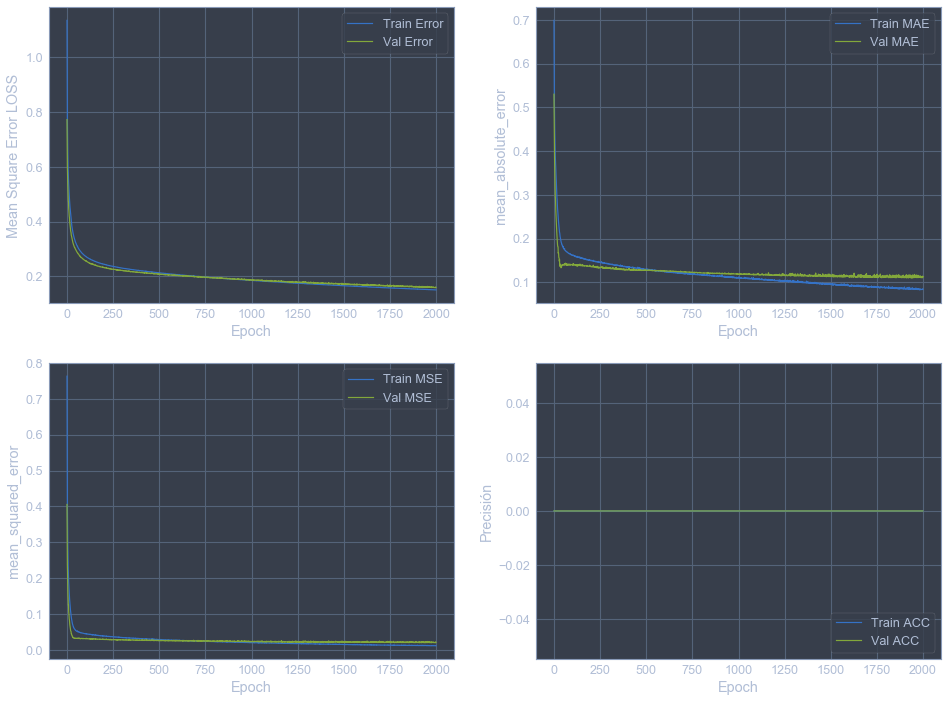

In [15]:
plot_history(history)

Ahora es momento de predecir ya que la red neuronal se encuentra entrenada

In [16]:
y_predic= model.predict(X_test)

Es posible calcular la diferencia entre la prediccion y los datos tomados desde la serie de tiempo

In [17]:
r = y_test - y_predic
ab = abs(r)

Ahora se puede revizar unos datos interesantes

In [18]:
print('Media:', r.mean())
print('Maximo:', ab.max())
print('Minimo:', ab.min())
print('STD:', r.std())

Media: -0.016050704326878485
Maximo: 0.4231649866765417
Minimo: 0.002885158142811539
STD: 0.17568691247346882


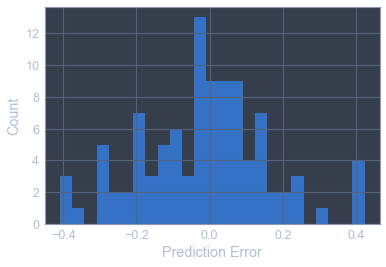

In [19]:
plt.hist(r, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [20]:
Y_inv = y_test*std + mean
Y_pred_inv = y_predic*std + mean

In [21]:
ERR = np.sqrt(mean_squared_error(Y_inv,Y_pred_inv)) 
ERR 

2.714700294990149

In [22]:
print(Y_inv.max())
ERR*100/Y_inv.max()

120.3092497096122


2.256435229662359

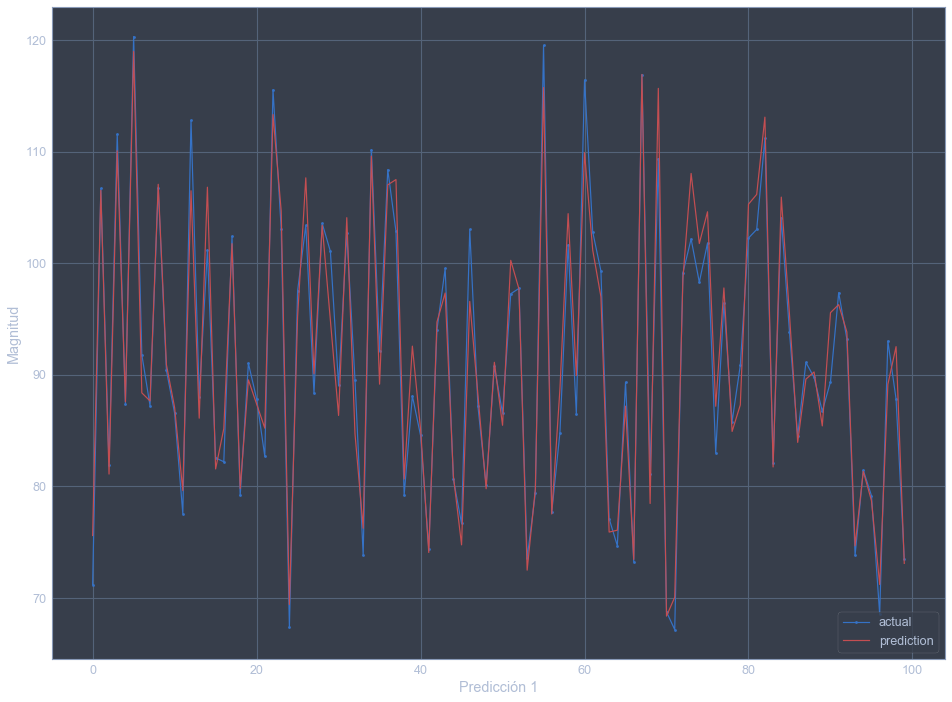

In [23]:
Y_inv = y_test*std + mean
Y_pred_inv = y_predic*std + mean

plt.figure(figsize=(16, 12))
plt.xlabel('Predicción 1')
plt.ylabel('Magnitud')
plt.plot(Y_inv[:, 0],marker='.', label="actual")
plt.plot(Y_pred_inv[:, 0], 'r', label="prediction")
plt.legend(loc="lower right")
plt.show()

<h3>Guardar el modelo entrenado </h3>

In [24]:
#model.save('modelo_serie_electrica3.h5')